In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import openai
import random
import os
import copy
import collections 
import scipy.stats as stats
import netgraph
import powerlaw as pwl
import seaborn as sns
import replicate
import anthropic
import hashlib
from utils import get_response, summarize_reasons

MEDIUM_SIZE = 24
SMALL_SIZE = 0.85 * MEDIUM_SIZE
BIGGER_SIZE = 1.5 * MEDIUM_SIZE

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
               
def draw_graph(G, ax, G0=None, use_netgraph=True, nodecolor='#d35400'):
    if not G0:
        G0_edges = set()
    else:
        G0_edges = set(G0.edges())
    G_edges = set(G.edges()) - G0_edges
    if not use_netgraph:
        pos = nx.spring_layout(G)

        if not G0:
            nx.draw(G, pos, ax=ax, node_size=10, width=1.5, node_color='#d35400', alpha=0.7, edge_color='#34495e')
        else:


            nx.draw_networkx_edges(G, pos, edgelist=G0_edges, width=1.5, alpha=0.5, edge_color='#34495e', ax=ax)
            nx.draw_networkx_edges(G, pos, edgelist=G_edges, width=1.5, alpha=1, edge_color='#e67e22', ax=ax)

            nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes()), node_size=10, node_color=nodecolor, alpha=0.7, ax=ax)
    else:
        edge_color = {(u, v) : '#34495e' if (u, v) in G0_edges else '#e67e22'  for (u, v) in G.edges()}

        netgraph.Graph(G, node_layout='spring', node_color=nodecolor, node_size=1.0, edge_color=edge_color, ax=ax)

    ax.set_axis_off()

def network_growth(T, n0, temperature, model, environment, role, cot, hash_and_shuffle, degrees, method='llm'):
    G = nx.empty_graph(n0)

    # G = nx.erdos_renyi_graph(n0, 0.5)

    Gs = []
    results = []

    for t in range(n0, n0 + T):
        print(f'Adding node {t}')
        if t > 0:
            if method == 'llm':
                result = select_neighbor(G, t, temperature, degrees=degrees, model=model, environment=environment, role=role, cot=cot, hash_and_shuffle=hash_and_shuffle)
            elif method == 'ba':
                result = {'name' : random.choice(list(G.nodes(), weights=[G.degree(n) for n in G.nodes()]))}

        G.add_node(t)
        
        if t > 0 and result:
            v = result['name']
            G.add_edge(t, v)

        Gs.append(G.copy())
        results.append(result)

    return Gs, results

def select_neighbor(G, t, temperature, model, environment, role, degrees, cot, hash_and_shuffle):
    candidates = []
    if hash_and_shuffle:
        hash2idx = {}
        idx2hash = {}

        # sha256 hash of each node
        for v in list(G.nodes()) + [0]:
            h = str(hashlib.sha256(str(v).encode()).hexdigest())
            hash2idx[h] = str(v)
            idx2hash[str(v)] = h

    for v in G.nodes():
        if v != t:
            if degrees:
                candidates.append({'name' : v, 'number_of_friends' : G.degree(v)})
            else:
                nbrs = list(G.neighbors(v))
                if hash_and_shuffle:
                    nbrs = [idx2hash[str(n)] for n in nbrs]
                    candidates.append({'name' : idx2hash[str(v)], 'friends' : nbrs})
                else:
                    candidates.append({'name' : v, 'friends' : nbrs})

    # if len(candidates) > 200:
    #     candidates = random.sample(candidates, 200)

    if cot: 
        output_format = f"""
    {{
        "reason" : reason for selecting the person,
        "name" : name of the person you selected
    }}
        """
    else:
        output_format = f"""
    {{
        "name" : name of the person you selected,
        "reason" : reason for selecting the person
    }}
        """

    preferential_attachment_prompt = f"""
    # Task
    {f'You are in a {environment}.' if environment else ''}Your task is to select a person to be {role} with.

    # Input
    The input is a list of dictionaries. 
    
    The profiles are given below after chevrons:
    
    <PROFILES>
    {json.dumps(candidates)}
    </PROFILES>

    # Output
    The output should be given in JSON format with the following structure

    {output_format}

    # Notes

    * The name of the person you selected must be one of the names in the input.
    * Your output must be JSON only.

    ```json
    """

    for i in range(10):
        ans = get_response(preferential_attachment_prompt, model, temperature=temperature)
        try:
            try:
                result = json.loads(ans.split('```')[0])
            except:
                result = json.loads(ans.split('```json')[1].split('```')[0])

            if not hash_and_shuffle and result['name'] in G.nodes():
                print('NEW EDGE', result)
                return result
            elif hash_and_shuffle and result['name'] in hash2idx:
                result['name'] = int(hash2idx[result['name']])
                print('NEW EDGE', result)
                return result
        except Exception as e:
            print(e)
        
def run_network_formation_experiment(n_min, n_max, n_step, num_simulations, outfile, temperatures, environment=None, role='friends', degrees=True, model='gpt-3.5-turbo', cot=False, hash_and_shuffle=False):

    saved_scenarios = set()

    if os.path.exists(outfile):
        with open(outfile) as f:
            lines = f.read().splitlines()

            for line in lines:
                scenario = json.loads(line)
                saved_scenarios.add((scenario['n'], scenario['simulation'], scenario['temperature']))

        exit()

    f = open(outfile, 'a+')

    print(saved_scenarios)

    for n in range(n_min, n_max + 1, n_step):
        for i in range(num_simulations):
            for temperature in temperatures:
                if (n, i, temperature) in saved_scenarios:
                    print(f'Skipping simulation for n={n}, i={i}, temperature={temperature}')
                    continue
                else:
                    print(f'Running simulation for n={n}, i={i}, temperature={temperature}')
                    n0 = 1
                    Gs, reasons = network_growth(n, n0, temperature=temperature, degrees=degrees, model=model, environment=environment, role=role, cot=cot, hash_and_shuffle=hash_and_shuffle)

                    temp = {
                        'n' : n,
                        'n0' : n0,
                        'temperature' : temperature,
                        'simulation' : i,
                        'graphs' : [nx.to_dict_of_lists(G) for G in Gs],
                        'reasons' : reasons
                    }    

                    f.write(json.dumps(temp) + '\n')            

    f.close()

def analyze_experiments(filename, dgr=True):

    suffix = os.path.split(os.path.splitext(filename)[0])[-1]

    palette = ['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']

    with open(filename) as f:
        lines = f.read().splitlines()

    data = []

    for line in lines:
        data.append(json.loads(line))

    degree_freqs = collections.defaultdict(list)
    dergee_freqs_barabasi_albert = collections.defaultdict(list)

    wasserstein_distances = collections.defaultdict(list)
    ks_statistics = collections.defaultdict(list)
    gammas = collections.defaultdict(list)
    gammas_barabasi_albert = collections.defaultdict(list)
    sigmas = collections.defaultdict(list)
    sigmas_barabasi_albert = collections.defaultdict(list)
    ks_powerlaw = collections.defaultdict(list)
    confidence_ks_intervals = collections.defaultdict(list)
    pwl_fits = collections.defaultdict(list)
    pwl_fits_barabasi_albert = collections.defaultdict(list)

    final_graphs = collections.defaultdict(list)

    for d in data:
        Gs = []
        for graph in d['graphs']:
            G = nx.Graph()

            for k, v in graph.items():
                k = int(k)
                G.add_node(k)
                for n in v:
                    G.add_edge(k, n)

            G.remove_nodes_from(list(nx.isolates(G)))
            Gs.append(G)

        final_graphs[d['n'], d['temperature']].append((Gs[-1].copy(), Gs[0].copy()))

        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        fig_barabasi_albert, ax_barabasi_albert = plt.subplots(1, 2, figsize=(10, 5))
    
        # fig.suptitle(f'Graph created based on Principle 1 with $n = {d["n"]}$, $n_0 = {d["n0"]}$, temperature = {d["temperature"]}')

        G_barabasi_albert = nx.barabasi_albert_graph(n=d['n'], m=1, seed=1)

        for i, t in enumerate([len(Gs) // 3, 2 * len(Gs) // 3, len(Gs) - 1]):
            G = Gs[t]
            ax[i].set_title(f'$t = {t}$')
            if len(Gs[0]) > 2:
                draw_graph(G, ax=ax[i], G0=Gs[0])
            else:
                draw_graph(G, ax=ax[i])
            
        draw_graph(G_barabasi_albert, ax=ax_barabasi_albert[0], nodecolor='#3498db')


        degrees = [G.degree(n) for n in G.nodes()]
        degrees_barabasi_albert = [G_barabasi_albert.degree(n) for n in G_barabasi_albert.nodes()]

        powerlaw_fit = pwl.Fit(degrees, discrete=True)

        print(f'Temperature {d["temperature"]}: xmin: {powerlaw_fit.xmin}, alpha: {powerlaw_fit.alpha}, sigma: {powerlaw_fit.sigma}')

        powerlaw_fit_barabasi_albert = pwl.Fit(degrees_barabasi_albert, discrete=True)

        wasserstein_distances[d['n'], d['temperature']].append(stats.wasserstein_distance(degrees, degrees_barabasi_albert))
        gammas[d['n'], d['temperature']].append(powerlaw_fit.alpha)
        sigmas[d['n'], d['temperature']].append(powerlaw_fit.sigma)

        gammas_barabasi_albert[d['n'], d['temperature']].append(powerlaw_fit_barabasi_albert.alpha)
        sigmas_barabasi_albert[d['n'], d['temperature']].append(powerlaw_fit_barabasi_albert.sigma)

        ks_powerlaw[d['n'], d['temperature']].append(powerlaw_fit.power_law.KS(degrees))

        ax[-1].set_title('Degree distribution')
        ax[-1].spines[['right', 'top']].set_visible(False)

        ax_barabasi_albert[-1].set_title('Degree distribution')

        powerlaw_fit.plot_ccdf(linewidth=3, ax=ax[-1], color='#e74c3c', label='LLM (Empirical)')
        powerlaw_fit_barabasi_albert.plot_ccdf(linewidth=3, ax=ax[-1], color='#3498db', label='BA (Empirical)')

        powerlaw_fit_barabasi_albert.plot_ccdf(linewidth=3, ax=ax_barabasi_albert[-1], color='#3498db', label='BA (Empirical)')

        powerlaw_fit.power_law.plot_ccdf(ax=ax[-1], color='#e74c3c', linestyle='--', label='LLM (Power law fit)')
        powerlaw_fit_barabasi_albert.power_law.plot_ccdf(ax=ax[-1], color='#3498db', linestyle='--', label='BA (Power law fit)')

        powerlaw_fit_barabasi_albert.power_law.plot_ccdf(ax=ax_barabasi_albert[-1], color='#3498db', linestyle='--', label='BA (Power law fit)')

        print(f'BA powerlaw fit gamma: {powerlaw_fit_barabasi_albert.power_law.alpha:.2f} +- {powerlaw_fit_barabasi_albert.power_law.sigma:.2f}')

        pwl_fits[d['n'], d['temperature']].append(powerlaw_fit)
        pwl_fits_barabasi_albert[d['n'], d['temperature']].append(powerlaw_fit_barabasi_albert)

        print(f'Temperature: {d["temperature"]}, KS Test with BA (empirical): {stats.ks_2samp(degrees, degrees_barabasi_albert)}')
        print()
      
        # Exports to perform bootstrap hypothesis test in R using the poweRlaw package
        df = pd.DataFrame(degrees)
        df.to_csv(f'degrees{"_neighbors" if not dgr else ""}_{d["n"]}_{d["simulation"]}_{d["temperature"]}.txt', header=None, index=False)

        ax[-1].legend()
        ax[-1].set_xlabel('Degree')
        ax[-1].set_ylabel('CCDF')
        ax[-1].spines[['right', 'top']].set_visible(False)


        ax_barabasi_albert[-1].legend()
        ax_barabasi_albert[-1].set_xlabel('Degree')
        ax_barabasi_albert[-1].set_ylabel('CCDF')

        fig.tight_layout()

        fig.suptitle(f'Temperature = {d["temperature"]}', y=1.05)
        fig_barabasi_albert.suptitle('BA Model', y=1.05)

        fig.savefig(f'figures/principle_1/{suffix}_{d["n"]}_{d["simulation"]}_{d["temperature"]}{"_neighbors" if not dgr else ""}.png', dpi=300, bbox_inches='tight')
        fig_barabasi_albert.savefig(f'figures/principle_1/{suffix}_{d["n"]}_{d["simulation"]}_{d["temperature"]}_barabasi_albert{"_neighbors" if not dgr else ""}.png', dpi=300, bbox_inches='tight')

    # fig, ax = plt.subplots(1, len(degree_freqs), figsize=(5 * len(degree_freqs), 5))

    # for i, k in enumerate(sorted(degree_freqs)):

    #     degree_freq = np.mean(degree_freqs[k], axis=0)
    #     degree_freq_barabasi_albert = np.mean(dergee_freqs_barabasi_albert[k], axis=0)

    #     ax[i].set_title(f'$n = {k[0]}$, temperature={k[1]}')
    #     ax[i].loglog(degree_freq, color='#16a085', marker='x', label='LLM')
    #     ax[i].loglog(degree_freq_barabasi_albert, color='#2980b9', marker='x', label='BA') 
    #     ax[i].set_xlabel('Degree')
    #     ax[i].set_ylabel('Frequency')

    # fig.tight_layout()
    # fig.savefig(f'figures/principle_1/principle_1_overall.png')

    fig, ax = plt.subplots(1, 1 + len(final_graphs), figsize=(5 * (1 + len(final_graphs)), 5), squeeze=False, gridspec_kw={'width_ratios': [1] * (1 + len(final_graphs))})
    # fig.suptitle(f'Graphs created based on Principle 1 with $n = {d["n"]}$, $n_0={d["n0"]}$')

    for i, k in enumerate(sorted(final_graphs.keys())):
        G, G0 = final_graphs[k][0]
        
        if len(G0) > 2:
            draw_graph(G, ax[0, i], G0=G0, nodecolor=palette[i])
        else:
            draw_graph(G, ax[0, i], nodecolor=palette[i])
        ax[0, i].set_title(f'Temperature = {k[-1]}')


    for i, k in enumerate(sorted(pwl_fits.keys())):
        powerlaw_fit = pwl_fits[k][0]
        powerlaw_fit.plot_ccdf(linewidth=3, ax=ax[0, -1], color=palette[i], label=str(k[-1]))
        powerlaw_fit.power_law.plot_ccdf(ax=ax[0, -1], color=palette[i], linestyle='--')
    

    for i, k in enumerate(sorted(pwl_fits.keys())):

        powerlaw_fit_barabasi_albert = pwl_fits_barabasi_albert[k][0]

        if i == 0:
            powerlaw_fit_barabasi_albert.plot_ccdf(linewidth=3, ax=ax[0, -1], color='#7f8c8d', label='BA')
            powerlaw_fit_barabasi_albert.power_law.plot_ccdf(ax=ax[0, -1], color='#7f8c8d', linestyle='--')


    ax[0, -1].legend()
    ax[0, -1].set_xlabel('Degree')
    ax[0, -1].set_ylabel('Complementary CDF')
    ax[0, -1].spines[['right', 'top']].set_visible(False)

    fig.tight_layout()

    fig.savefig(f'figures/principle_1/{suffix}_final_graphs{"_neighbors" if not dgr else ""}.png', dpi=300)


def analyze_experiments_multiple_llms(filenames, sfx=''):

    records = []

    for filename in filenames:
        suffix = os.path.split(os.path.splitext(filename)[0])[-1]
        suffix = suffix.split('+')
        
        with open(filename) as f:
            lines = f.read().splitlines()

        data = []

        for line in lines:
            data.append(json.loads(line))

        for d in data:
            Gs = []
            for graph in d['graphs']:
                G = nx.Graph()

                for k, v in graph.items():
                    k = int(k)
                    G.add_node(k)
                    for n in v:
                        G.add_edge(k, n)

                G.remove_nodes_from(list(nx.isolates(G)))
                Gs.append(G)

            G_barabasi_albert = nx.barabasi_albert_graph(n=d['n'], m=1, seed=1)

            G = Gs[-1]

            degrees = np.array([G.degree(n) for n in G.nodes()])
            degrees_barabasi_albert = np.array([G_barabasi_albert.degree(n) for n in G_barabasi_albert.nodes()])


            powerlaw_fit = pwl.Fit(degrees, discrete=True)

            wasserstein_distance = stats.wasserstein_distance(degrees, degrees_barabasi_albert)
            gamma = powerlaw_fit.alpha
            sigma = powerlaw_fit.sigma

            if len(suffix) == 3:
                model = suffix[-2]
                environment = suffix[-1]
            elif len(suffix) == 2:
                model = suffix[-1]
                environment = 'Baseline'
            else:
                environment = 'Baseline'

            ks_stats = stats.ks_2samp(degrees, degrees_barabasi_albert)

            if ks_stats[1] < 0.001:
                stars = '***'
            elif ks_stats[1] < 0.01:
                stars = '**'
            elif ks_stats[1] < 0.05:
                stars = '*'
            else:
                stars = 'p = {:.3f}'.format(ks_stats[1])


            # top k plot info

            degrees = np.sort(degrees)[::-1]

            # insert 0 at the beginning
            degrees = np.insert(degrees, 0, 0)
            degrees_cumsum = np.cumsum(degrees)
            probability_of_topk_yaxis = degrees_cumsum / degrees_cumsum[-1]

            probability_of_topk_xaxis = np.arange(len(degrees)) / len(degrees)
        
            record = {
                'Model' : model,
                'Environment' : environment,
                'Temperature' : d['temperature'],
                '$\\hat \\gamma$' : gamma,
                '$\\sigma$' : sigma,
                'KS Test' : f'{ks_stats[0]:.3f} ({stars})',
                'Probability of Connecting to Top-$k$' : probability_of_topk_yaxis,
                'Top-$k$' : probability_of_topk_xaxis
            }

            records.append(record)

    G_barabasi_albert = nx.barabasi_albert_graph(n=d['n'], m=1, seed=1)
    degrees_barabasi_albert = [G_barabasi_albert.degree(n) for n in G_barabasi_albert.nodes()]
    powerlaw_fit = pwl.Fit(degrees_barabasi_albert, discrete=True)
    gamma = powerlaw_fit.alpha
    sigma = powerlaw_fit.sigma

    record = {
        'Model' : 'Barabasi-Albert',
        'Environment' : 'Baseline',
        'Temperature' : None,
        '$\\hat \\gamma$' : gamma,
        '$\\sigma$' : sigma,
        'KS Test' : None
    }

    records.append(record)

    df = pd.DataFrame.from_records(records)


    df.to_csv('tables/exponents.csv', index=False)
    df.to_latex('tables/exponents.tex', index=False, escape=False, float_format="%.3f")

    rename_models = {
        'gpt-3.5-turbo' : 'GPT-3.5',
        'gpt-4o-mini' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct' : 'LLAMA-3',
        'meta-meta-llama-3-8b-instruct' : 'LLAMA-3-8b',
        'claude-3-5-sonnet-20240620' : 'Claude 3.5',
        'gpt-3.5-turbo_cot' : 'GPT-3.5',
        'gpt-4o-mini_cot' : 'GPT-4 Mini',
        'meta-meta-llama-3-70b-instruct_cot' : 'LLAMA-3',
        'meta-meta-llama-3-8b-instruct_cot' : 'LLAMA-3',

        'claude-3-5-sonnet-20240620_cot' : 'Claude 3.5',
    }

    rename_environment = {
        'school' : 'School',
        'community' : 'Community',
        'work' : 'Work',
        'school_cot' : 'School',
        'community_cot' : 'Community',
        'work_cot' : 'Work'
    }


    df['Model'] = df['Model'].apply(lambda x: rename_models.get(x, x))
    df['Environment'] = df['Environment'].apply(lambda x: rename_environment.get(x, x))


    df_model = df.query('Environment == "Baseline" and Temperature == 1.0')
    df_model = df_model[df_model['Model'] != 'Barabasi-Albert']

    df_environment = df.query('Model == "GPT-3.5" and Temperature == 1.5')
    df_temperature = df.query('Model == "GPT-3.5" and Environment == "Baseline"')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    sc_model = sns.barplot(data=df_model, y='$\\hat \\gamma$', x='Model', ax=ax[0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
    sc_temperature = sns.barplot(data=df_temperature, y='$\\hat \\gamma$', x='Temperature', ax=ax[1], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
    sc_environment = sns.barplot(data=df_environment, y='$\\hat \\gamma$', x='Environment', ax=ax[2], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])




    sc_model.set_xticklabels(sc_model.get_xticklabels(), rotation=90)
    sc_temperature.set_xticklabels(sc_temperature.get_xticklabels(), rotation=90)
    sc_environment.set_xticklabels(sc_environment.get_xticklabels(), rotation=90)

    ax[0].errorbar(df_model['Model'], df_model['$\\hat \\gamma$'], yerr=df_model['$\\sigma$'], color='black', linestyle='', capsize=10, alpha=0.5)
    ax[1].errorbar(['0.5', '1.0', '1.5'], df_temperature['$\\hat \\gamma$'], yerr=df_temperature['$\\sigma$'], color='black', linestyle='', capsize=10, alpha=0.5)
    ax[2].errorbar(df_environment['Environment'], df_environment['$\\hat \\gamma$'], yerr=df_environment['$\\sigma$'], color='black', linestyle='', capsize=10, alpha=0.5)



    gamma_ba = df[df['Model'] == 'Barabasi-Albert']['$\\hat \\gamma$'].values[0]
    sigma_ba = df[df['Model'] == 'Barabasi-Albert']['$\\sigma$'].values[0]

    # draw baraasi-albert line
    ax[0].axhline(y=gamma_ba, color='#c0392b', linestyle='--', label='BA (Sample)', linewidth=3)
    ax[1].axhline(y=gamma_ba, color='#c0392b', linestyle='--', label='BA (Sample)', linewidth=3)
    ax[2].axhline(y=gamma_ba, color='#c0392b', linestyle='--', label='BA (Sample)', linewidth=3)

    ax[0].axhline(y=3, color='#34495e', linestyle=':', label='BA (Theoretical)', linewidth=3)
    ax[1].axhline(y=3, color='#34495e', linestyle=':', label='BA (Theoretical)', linewidth=3)
    ax[2].axhline(y=3, color='#34495e', linestyle=':', label='BA (Theoretical)', linewidth=3)

    ax[0].legend(fontsize=0.7*SMALL_SIZE)

    ax[0].set_ylim(1, 5)
    ax[1].set_ylim(1, 5)
    ax[2].set_ylim(1, 5)

    ax[1].set_ylabel('')
    ax[2].set_ylabel('')

    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[2].set_xlabel('')

    ax[0].set_title('Model')
    ax[1].set_title('Temperature')
    ax[2].set_title('Environment')


    ax[1].get_yaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)

    ax[0].spines[['right', 'top']].set_visible(False)
    ax[1].spines[['right', 'top']].set_visible(False)
    ax[2].spines[['right', 'top']].set_visible(False)

    # fig.tight_layout()

    fig.savefig(f'figures/exponents{sfx}.png', dpi=300, bbox_inches='tight')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # plot probability of connecting to top-k

    palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9']



    breakpoints_arr = [('top', np.array([0.01, 0.015, 0.02, 0.025])), ('all', np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]))]

    for label, breakpoints in breakpoints_arr:

        breakpoint_max = np.max(breakpoints)
        breakpoint_min = np.min(breakpoints)

        fig.suptitle('Probability of Connecting to Top-$k$ Degrees', fontsize=SMALL_SIZE)

        for i in range(len(ax)):
            ax[i].plot([0, 100 * breakpoint_max], [0, breakpoint_max], color='black', linestyle='--')
            ax[i].set_xlim(100 * breakpoint_min, 100 * breakpoint_max)

        for i, model in enumerate(df_model['Model']):
            n = len(df_model['Top-$k$'].values[i])
            indices = np.array([int(x * n) for x in breakpoints])
            jitter = np.random.uniform(0, 0.1) * np.ones(len(indices))

            color = palette[i]
            linewidth = 1

            if model == 'GPT-3.5' and df_model['Environment'].values[i] == 'Baseline' and df_model['Temperature'].values[i] == 1.0:
                color = '#34495e'
                linewidth = 3
            
            ax[0].plot(100 * df_model['Top-$k$'].values[i][indices] + jitter, df_model['Probability of Connecting to Top-$k$'].values[i][indices] + jitter, label=model, color=color, linewidth=linewidth, marker='x')

        ax[0].set_title('Model')
        ax[0].set_xlabel('Top-$k$ (%)')
        # ax[0].set_xscale('log')
        # ax[0].set_yscale('log')
        ax[0].set_ylabel('')
        
        ax[0].legend(fontsize=0.7*SMALL_SIZE, ncol=2)

        for i, temperature in enumerate(df_temperature['Temperature']):
            n = len(df_model['Top-$k$'].values[i])
            indices = np.array([int(x * n) for x in breakpoints])

            color = palette[i]

            color = palette[i]
            linewidth = 1

            if temperature == 1.5 and df_temperature['Model'].values[i] == 'GPT-3.5' and df_temperature['Environment'].values[i] == 'Baseline':
                color = '#34495e'
                linewidth = 3

            ax[1].plot(100 * df_temperature['Top-$k$'].values[i][indices], df_temperature['Probability of Connecting to Top-$k$'].values[i][indices], label=f'{temperature}', color=color, linewidth=linewidth, marker='x')

        ax[1].set_title('Temperature')
        ax[1].set_xlabel('Top-$k$ (%)')
        # ax[1].set_xscale('log')
        # ax[1].set_yscale('log')
        ax[1].set_ylabel('')

        ax[1].legend(fontsize=0.7*SMALL_SIZE)

        for i, environment in enumerate(df_environment['Environment']):
            n = len(df_model['Top-$k$'].values[i])
            indices = np.array([int(x * n) for x in breakpoints])

            color = palette[i]
            linewidth = 1

            if environment == 'Baseline' and df_environment['Model'].values[i] == 'GPT-3.5' and df_environment['Temperature'].values[i] == 1.5:
                color = '#34495e'
                linewidth = 3

            ax[2].plot(100 * df_environment['Top-$k$'].values[i][indices], df_environment['Probability of Connecting to Top-$k$'].values[i][indices], label=environment, color=color, linewidth=linewidth, marker='x')

        ax[2].set_title('Environment')
        ax[2].set_xlabel('Top-$k$ (%)')
        # ax[2].set_xscale('log')
        # ax[2].set_yscale('log')
        ax[2].set_ylabel('')

        ax[2].legend(fontsize=0.7*SMALL_SIZE, ncols=2)

        ax[0].set_ylim(0, 1)
        ax[1].set_ylim(0, 1)
        ax[2].set_ylim(0, 1)

        # hide y axis numbers
        ax[1].get_yaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)

        ax[0].spines[['right', 'top']].set_visible(False)
        ax[1].spines[['right', 'top']].set_visible(False)
        ax[2].spines[['right', 'top']].set_visible(False)

        fig.tight_layout()

        fig.savefig(f'figures/probabilitytopk_{label}_{sfx}.png', dpi=300, bbox_inches='tight')




{(200, 0, 1.5)}
Skipping simulation for n=200, i=0, temperature=1.5
{(200, 0, 1.5)}
Skipping simulation for n=200, i=0, temperature=1.5
{(200, 0, 1.5)}
Skipping simulation for n=200, i=0, temperature=1.5
{(200, 0, 1.5), (200, 0, 0.5), (200, 0, 1.0)}
Skipping simulation for n=200, i=0, temperature=0.5
Skipping simulation for n=200, i=0, temperature=1.0
Skipping simulation for n=200, i=0, temperature=1.5
{(200, 0, 1.5), (200, 0, 0.5), (200, 0, 1.0)}
Skipping simulation for n=200, i=0, temperature=0.5
Skipping simulation for n=200, i=0, temperature=1.0
Skipping simulation for n=200, i=0, temperature=1.5
{(200, 0, 1.5), (200, 0, 0.5), (200, 0, 1.0)}
Skipping simulation for n=200, i=0, temperature=0.5
Skipping simulation for n=200, i=0, temperature=1.0
Skipping simulation for n=200, i=0, temperature=1.5


/Users/marios/miniconda3/lib/python3.12/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


Calculating best minimal value for power law fit
Temperature 0.5: xmin: 1.0, alpha: 2.3794574243633813, sigma: 0.09729942465383049
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 0.5, KS Test with BA (empirical): KstestResult(statistic=np.float64(0.3200497512437811), pvalue=np.float64(1.417971504569805e-09), statistic_location=np.int64(1), statistic_sign=np.int8(1))

Calculating best minimal value for power law fit
Temperature 1.0: xmin: 1.0, alpha: 2.3794574243633813, sigma: 0.09729942465383049
Calculating best minimal value for power law fit
BA powerlaw fit gamma: 2.24 +- 0.24
Temperature: 1.0, KS Test with BA (empirical): KstestResult(statistic=np.float64(0.3200497512437811), pvalue=np.float64(1.417971504569805e-09), statistic_location=np.int64(1), statistic_sign=np.int8(1))

Calculating best minimal value for power law fit
Temperature 1.5: xmin: 1.0, alpha: 2.369229186197331, sigma: 0.09657798035899239
Calculating best minimal value

/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_74548/3070460920.py:541: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sc_model = sns.barplot(data=df_model, y='$\\hat \\gamma$', x='Model', ax=ax[0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_74548/3070460920.py:541: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sc_model = sns.barplot(data=df_model, y='$\\hat \\gamma$', x='Model', ax=ax[0], palette=['#e67e22', '#f1c40f', '#3498db', '#7f8c8d', '#c0392b', '#34495e', '#2980b9'])
/var/folders/8n/s26krq6n1vb_73jtxvb8k8th0000gn/T/ipykernel_74548/3070460920.py:542: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `

{(200, 0, 1.5), (200, 0, 0.5), (200, 0, 1.0)}
Skipping simulation for n=200, i=0, temperature=0.5
Skipping simulation for n=200, i=0, temperature=1.0
Skipping simulation for n=200, i=0, temperature=1.5


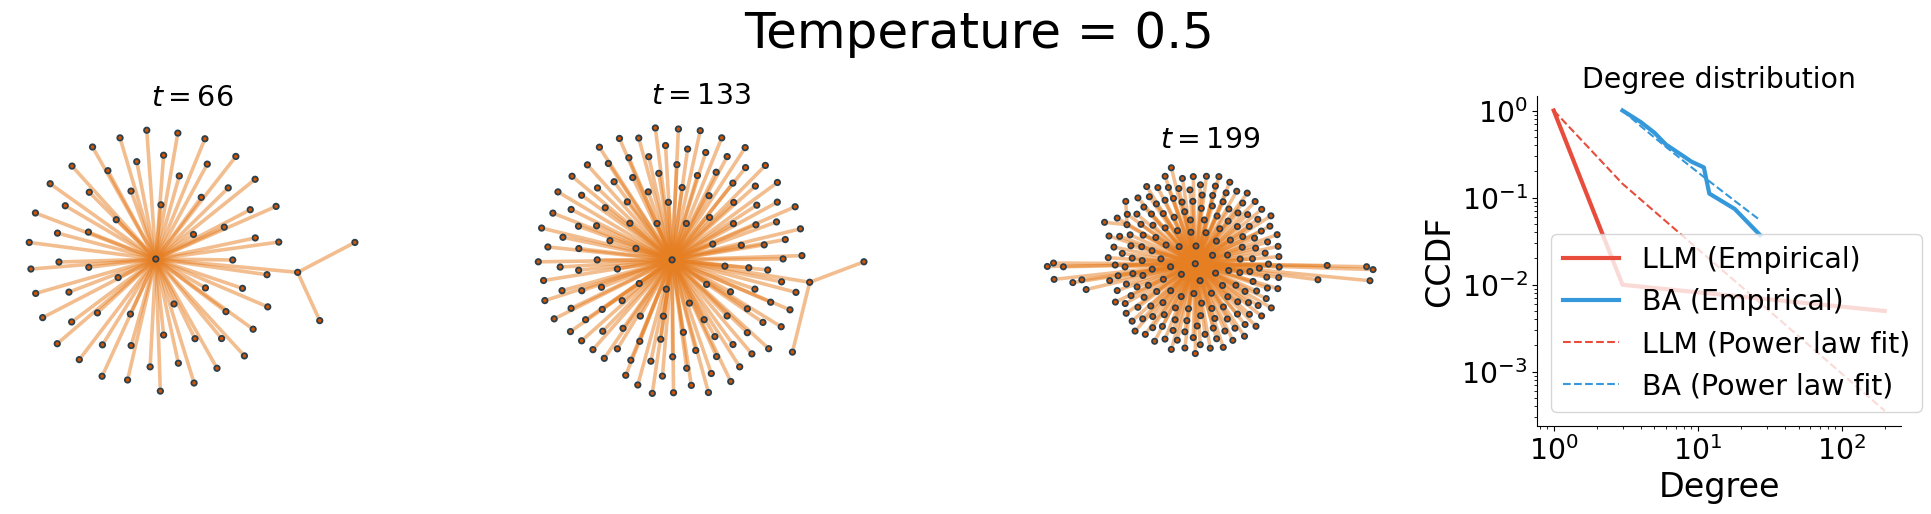

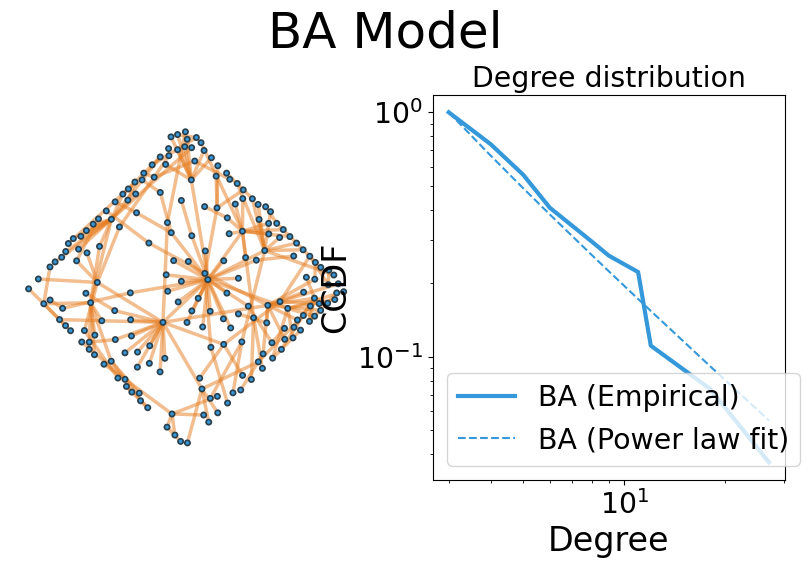

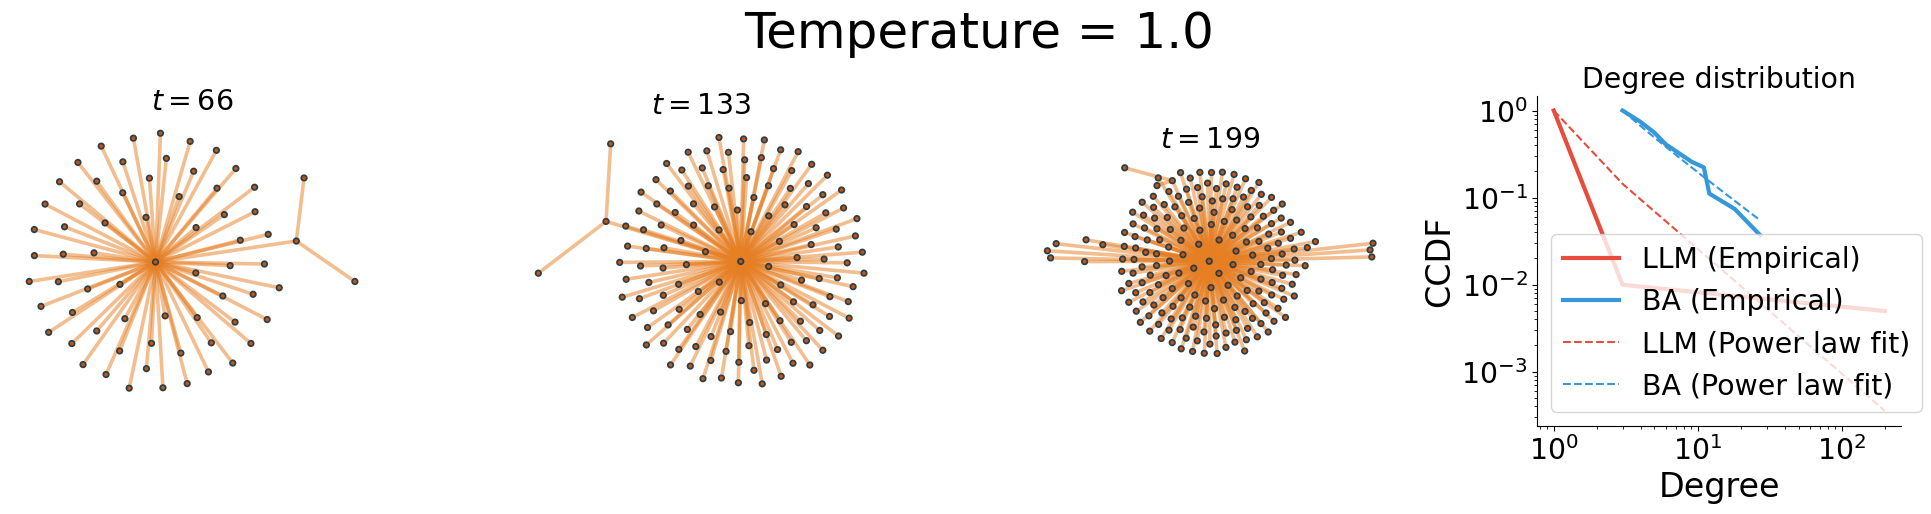

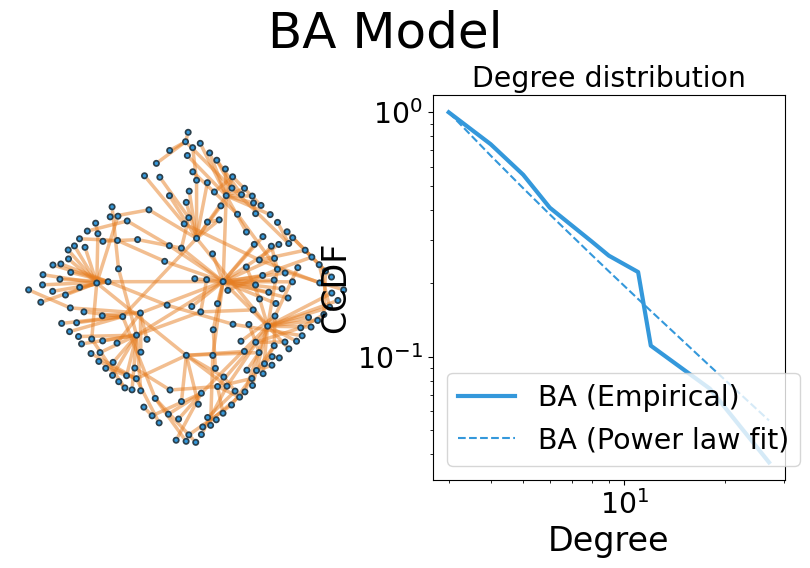

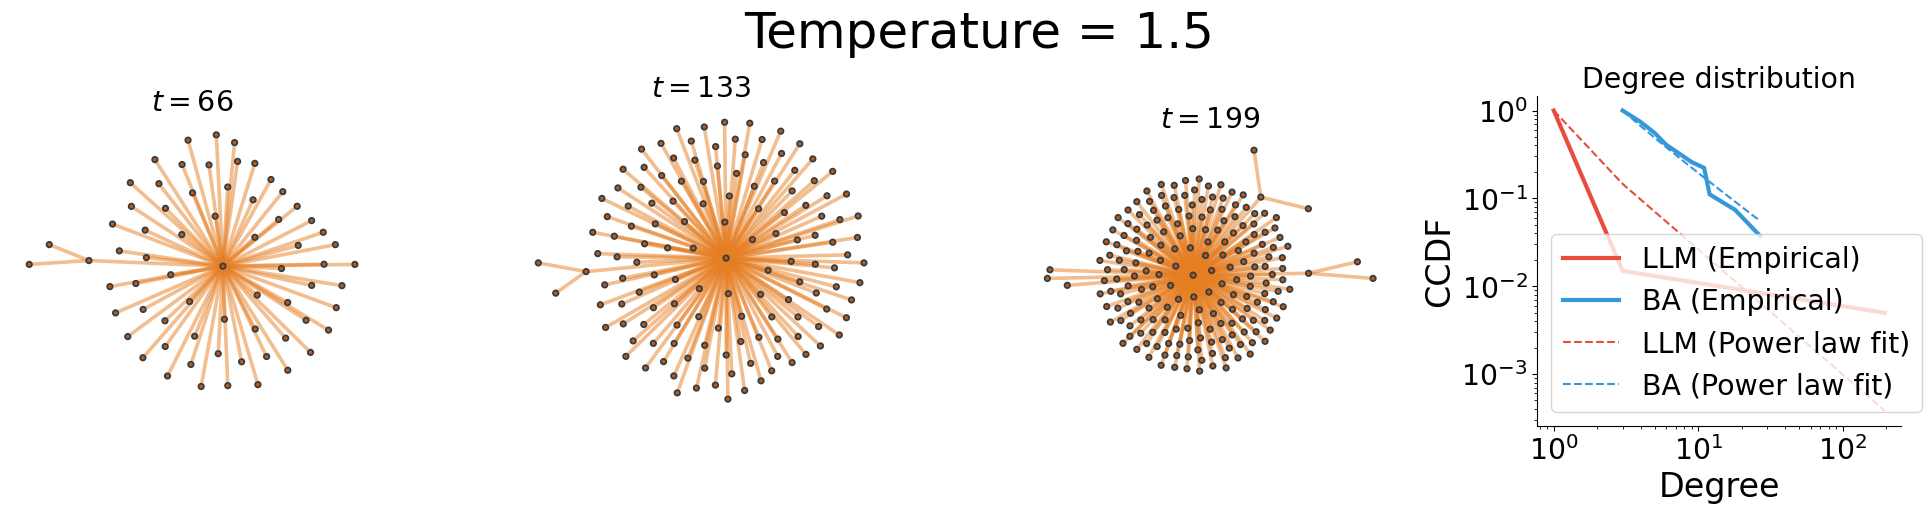

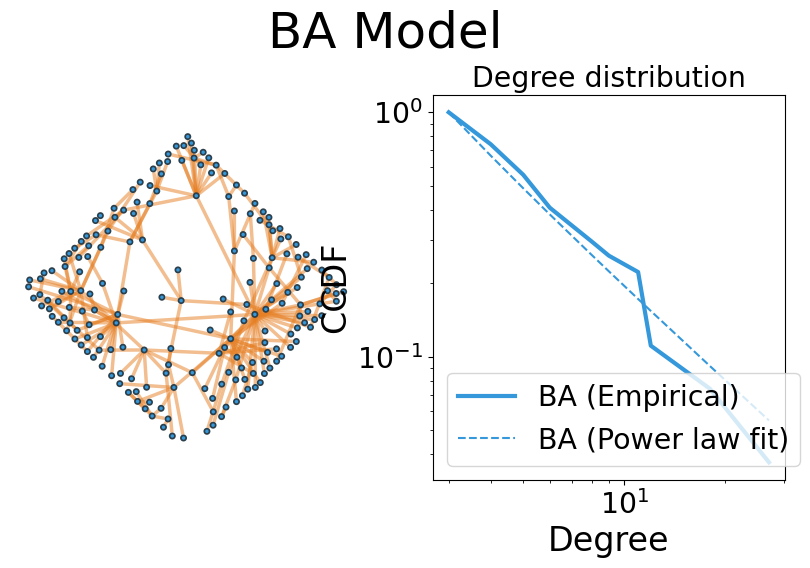

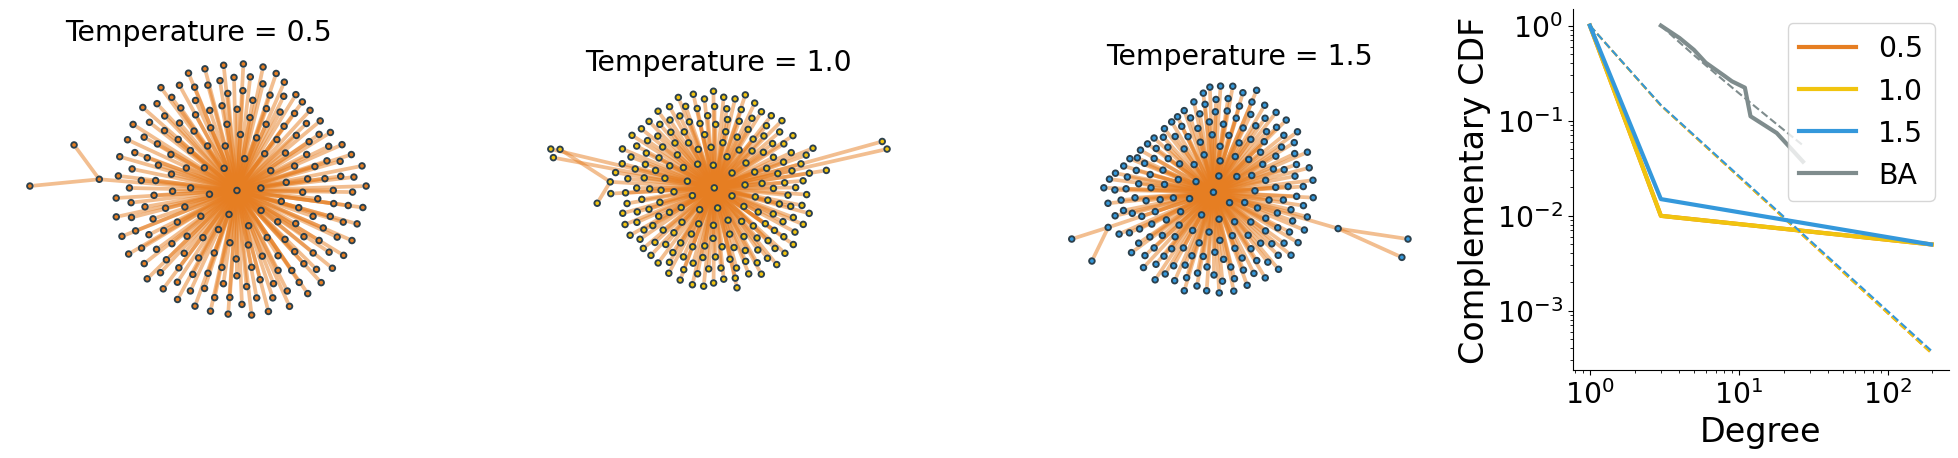

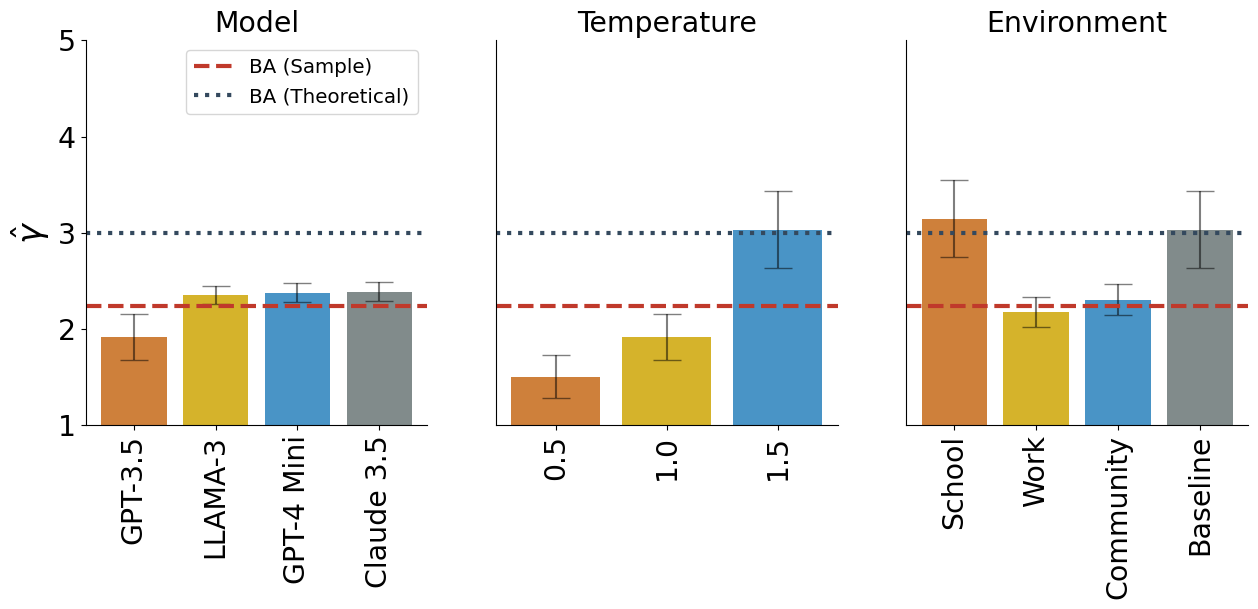

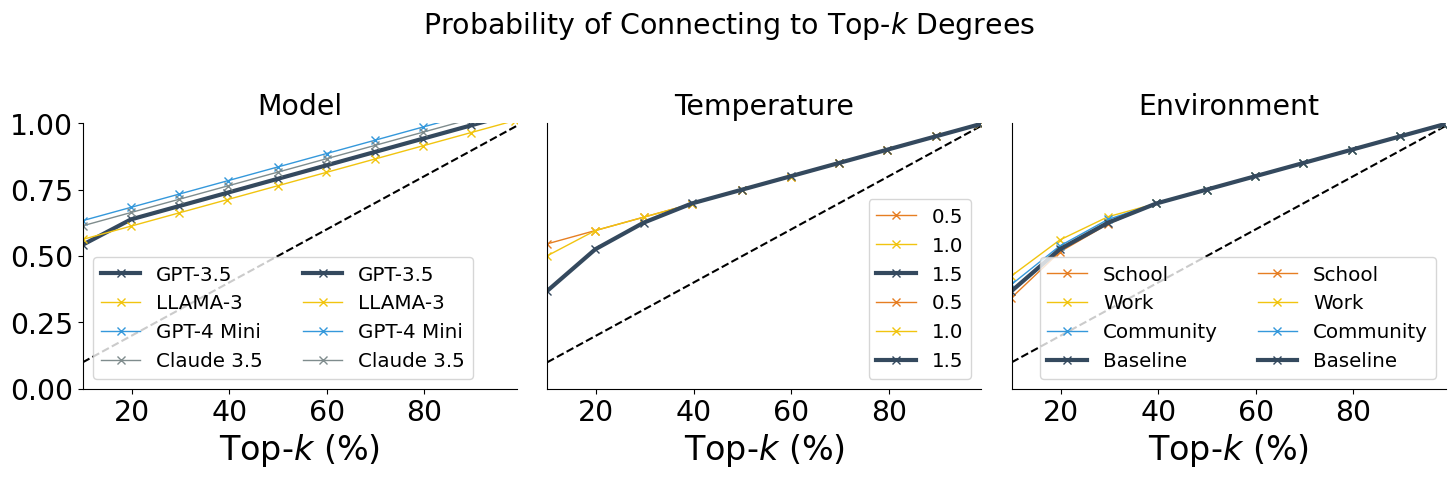

: 

In [ ]:
exponents_outfiles = []

# Other environments
for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_1_neighbors+gpt-3.5-turbo+{environment}.jsonl'
    run_network_formation_experiment(200, 200, 1, 1, outfile, [1.5], environment=environment, role=role, degrees=False)

    exponents_outfiles.append(outfile)

# Other models
for model in ['gpt-3.5-turbo', 'meta/meta-llama-3-70b-instruct', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620']:
    outfile = f'outputs/principle_1_neighbors+{model.replace("/", "-")}.jsonl'
    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(200, 200, 1, 1, outfile, [0.5, 1.0], degrees=False, model=model)
    else:
        run_network_formation_experiment(200, 200, 1, 1, outfile, [0.5, 1.0, 1.5], degrees=False, model=model)
    
    if model == 'gpt-4o-mini':
        analyze_experiments(outfile, dgr=False)

    exponents_outfiles.append(outfile)

analyze_experiments_multiple_llms(exponents_outfiles)

run_network_formation_experiment(200, 200, 1, 1, 'outputs/principle_1+gpt-3.5-turbo.jsonl', [0.5, 1.0, 1.5], degrees=True)
# analyze_experiments('outputs/principle_1+gpt-3.5-turbo.jsonl', dgr=True)


In [1]:
exponents_outfiles_cot = []

for environment, role in zip(['school', 'work', 'community'], ['classmates', 'colleagues', 'neighbors']):
    outfile = f'outputs/principle_1_neighbors+gpt-3.5-turbo+{environment}_cot.jsonl'
    run_network_formation_experiment(200, 200, 1, 1, outfile, [1.5], environment=environment, role=role, degrees=False, cot=True)

    exponents_outfiles_cot.append(outfile)

# Other models
for model in ['gpt-3.5-turbo', 'gpt-4o-mini', 'claude-3-5-sonnet-20240620', 'meta/meta-llama-3-70b-instruct']:
    outfile = f'outputs/principle_1_neighbors+{model.replace("/", "-")}_cot.jsonl'
    
    if model == 'claude-3-5-sonnet-20240620':
        run_network_formation_experiment(200, 200, 1, 1, outfile, [0.5, 1.0], degrees=False, model=model, cot=True)
    else:
        run_network_formation_experiment(200, 200, 1, 1, outfile, [0.5, 1.0, 1.5], degrees=False, model=model, cot=True)
    
    exponents_outfiles_cot.append(outfile)

analyze_experiments_multiple_llms(exponents_outfiles_cot, sfx='_cot')

NameError: name 'run_network_formation_experiment' is not defined